# 0 거리 계산을 위한 피처 맵  인덱스 고르기

## 0.0 임의의 데이터 생성을 위한 random 작업과 입력 데이터 크기 지정

In [1]:
import numpy as np

# 연습 데이터 랜덤 시드 설정
random_seed_id = 42
# 연습 데이터 범위 설정
random_start = 1; random_end = 1000000
# K는 피처 맵의 개수
K = 10000
# N은 행의 크기, M은 열의 크기
N = 36; M = 36

## 0.1 정분류 테스트 데이터 피처 맵(평균 피처 맵 포함) 생성

In [2]:
np.random.seed(random_seed_id + 4)

RFM_set = np.random.randint(random_start, random_end,
                            size=(K, N, M), dtype ="int32")
RFM_set = RFM_set - np.random.rand(K,N,M) # 이 부분을 추가하면 정수에서 실수로 됨
RFM_mean = np.zeros((N, M), dtype="float")
# 코드 일관성을 위해 첫 번째 데이터를 mean에 저장해두고 두 번째 부터 알고리즘 적용
RFM_mean += RFM_set[0]
for k in range(1, K):
    RFM_mean = (RFM_mean*k + RFM_set[k]) / (k+1)

## 0.2 훈련 데이터 평균 피처 맵(평균 피처 맵 포함) 생성

In [3]:
# 랜덤하게 나오는 값 고정
np.random.seed(random_seed_id + 123)

TFM_set = np.random.randint(random_start, random_end,
                            size=(K, N, M), dtype="int32")
TFM_set = TFM_set - np.random.rand(K,N,M)
TFM_mean = np.zeros((N, M), dtype="float")
# 코드 일관성을 위해 첫 번째 데이터를 mean에 저장해두고 두 번째 부터 알고리즘 적용
TFM_mean += TFM_set[0]
for k in range(1, K):
    TFM_mean = (TFM_mean*k + TFM_set[k]) / (k+1)

## 0.3 n*m 크기의 임의의 오분류 테스트 데이터의 피처 맵 K개 생성
* random.seed(42)로 랜덤하게 나오는 것을 일정하게 만들어준다
* 피처 맵 계산 연습을 위한 K개의 n*m 사이즈의 테스트 데이터셋 생성

In [4]:
np.random.seed(random_seed_id)

WFM_set = np.random.randint(random_start, random_end,
                            size=(K, N, M), dtype="int32")
WFM_set = WFM_set - np.random.rand(K,N,M)
WFM_mean = np.zeros((N, M), dtype="float")
# 코드 일관성을 위해 첫 번째 데이터를 mean에 저장해두고 두 번째 부터 알고리즘 적용
WFM_mean += WFM_set[0]
for k in range(1, K):
    WFM_mean = (WFM_mean*k + WFM_set[k]) / (k+1)


## 0.4 피처 맵 인덱스 구하기

1. alpha 구하기

In [5]:
w_minus_r_max_alpha = [0,0]

alpha_min = int(np.array([RFM_mean.min(), TFM_mean.min(), WFM_mean.min()]).min())
alpha_max = int(np.array([RFM_mean.max(), TFM_mean.max(), WFM_mean.max()]).max())

for alpha in range(alpha_min, alpha_max+1):
    # True - >1, False -> 0
    TAM = np.array(TFM_mean > alpha, dtype="int32")
    RAM = np.array(RFM_mean > alpha, dtype="int32")
    WAM = np.array(WFM_mean > alpha, dtype="int32")

    TAM_minus_RAM = TAM - RAM
    TAM_minus_WAM = TAM - WAM

    r = len(np.where(TAM_minus_RAM == 1)[0])
    w = len(np.where(TAM_minus_WAM == 1)[0])
    # w_minus_r_max_alpha의 인덱스 0이 w-r max이고, 인덱스 1이 alpha임
    if w-r > w_minus_r_max_alpha[0]:
        w_minus_r_max_alpha[0] = w-r
        w_minus_r_max_alpha[1] = alpha

alpha = w_minus_r_max_alpha[1]

2. 인덱스 구하기

In [16]:
RAM = RFM_mean > alpha
TAM = TFM_mean > alpha
WAM = WFM_mean > alpha

DAM = WAM.copy() # DAM = 거리 활성화 맵
TAM_and_RAM = np.logical_and(TAM, RAM)
np.place(DAM, TAM_and_RAM, 0)

nonzero_DAM = np.nonzero(DAM)
DAM_indexes = []
for i in range(len(nonzero_DAM[0])):
    DAM_indexes.append((nonzero_DAM[0][i], nonzero_DAM[1][i]))

# 아래 주석을 해제하면 전체 인덱스로 거리 계산하고 그게 아니라면 알고리즘으로 고른 인덱스로 거리 계산함 
# DAM_indexes = [(n,m) for n in range(N) for m in range(M)]

# 1 각 인덱스의 거리에 대한 중간값, 평균, 표준편차 행렬을 구함
* 각 인덱스 (i,j)에서 오분류 테스트 데이터의 피처 맵과 베이스 피처 맵 사이의 유클리드 거리를 K개 나열할 때 이에 대한 중간값, 평균, 표준편차를 저장하는 행렬들 생성

**중간값**과 **평균**과 **표준편차**도 저장함

In [17]:
# 각 인덱스 (i,j)에서 middle의 원소들은 그 인덱스 (i,j)에서 베이스 피처 맵와 오분류 테스트 데이터의 피처 맵의 거리를 K개 나열할 때

# 이 값들에 대한 중간값이어야 한다.
middle = np.empty((N,M), dtype="float")
mean = np.empty((N,M), dtype="float")
std = np.empty((N,M), dtype="float")
min = np.empty((N,M), dtype="float")
max = np.empty((N,M), dtype="float")

# ED를 가독성과 수정을 용이하게 하기 위해 람다로 만듦.
ED = lambda x, y: abs(x - y)

for n, m in DAM_indexes:
    ED_array_n_m = np.empty((0), dtype="float")
    for k in range(K):
        # 여기에서 '인덱스 간의 거리'를 어떻게 구할지 정하면 됨
        # ED_array_n_m를 numpy array로 만든 이유는
        # 각 인덱스의 중간값, 평균, 표준편차, 최소값, 최대값을 구하기 위함임.
        ED_array_n_m = np.append(ED_array_n_m, ED(TFM_mean[n][m],WFM_set[k][n][m]))
    
    # 각 인덱스에서 유클리드 거리에 대한 중간값 평균 표준편차를 구하는 것임.
    middle[n][m] = sorted(ED_array_n_m)[K // 2]
    mean[n][m] = ED_array_n_m.mean()
    std[n][m] = ED_array_n_m.std()
    min[n][m] = ED_array_n_m.min()
    max[n][m] = ED_array_n_m.max()

# 2 베이스 피처 맵과 테스트 데이터의 피처맵 사이의 거리를 구함.



### 2.1 처음 착수보고서에 작성된 거리를 구하는 알고리즘은 다음과 같음


* 알고리즘으로 거리를 구함

In [18]:
WFM_set_FMD = np.empty((0), dtype="float")
for k in range(K):
    WFM_k_FMD = 0
    for n, m in DAM_indexes:
        WFM_k_FMD += (ED(TFM_mean[n][m],WFM_set[k][n][m])
                     / middle[n][m])**2
    
    WFM_set_FMD = np.append(WFM_set_FMD, WFM_k_FMD)
# FMDC 출력
print("FMDC:", WFM_set_FMD.min())

FMDC: 520.2760085810024


* 알고리즘으로 구한 **거리에 대한 데이터들을 그래프**로 표현함

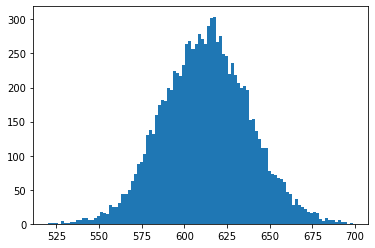

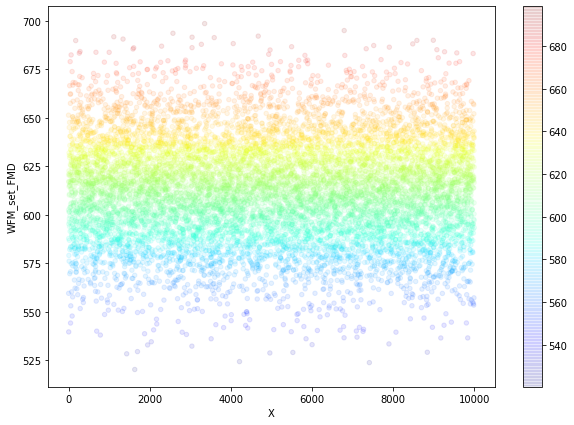

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

X = [k for k in range(K)]

Columns = ["WFM_set_FMD", "X"]

df_X_WFM_set_FMD = pd.DataFrame(np.append(WFM_set_FMD.reshape(1,K), np.array(X).reshape(1,K), axis=0).T, columns=Columns)

# 히스토그래프 그리기
plt.hist(WFM_set_FMD, bins=100)
# 데이터 분포와 크기에 따른 색상
df_X_WFM_set_FMD.plot(kind="scatter", x="X", y="WFM_set_FMD", alpha=0.1,
                      figsize=(10,7), c=df_X_WFM_set_FMD["WFM_set_FMD"],
                      cmap=plt.get_cmap("jet"), colorbar=True, sharex=False)

plt.show()

## 2.2 정규화를 시켜서 거리를 구함

* 정규화시키면 대략적으로 0보다 작은 값이 절반이고 0보다 큰 값이 절반 정도이다.  
* 따라서, exponential 함수를 쓰면 작은 값은 더 작아지고 큰 값은 더 커질 수 있다.  
* 그것에 대한 알고리즘을 짜려고 한다.

In [20]:
from math import exp

WFM_set_FMD = np.empty((0), dtype="float")
for k in range(K):
    WFM_k_FMD = 0
    for n, m in DAM_indexes:
        WFM_k_FMD += exp(((ED(TFM_mean[n][m],WFM_set[k][n][m])
                             - middle[n][m]) / std[n][m]))
    
    WFM_set_FMD = np.append(WFM_set_FMD, WFM_k_FMD)
# FMDC 출력
print("FMDC:", WFM_set_FMD.min())

FMDC: 615.3544898635065


* 거리에 대한 그래프를 그린다.

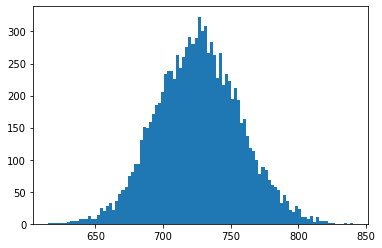

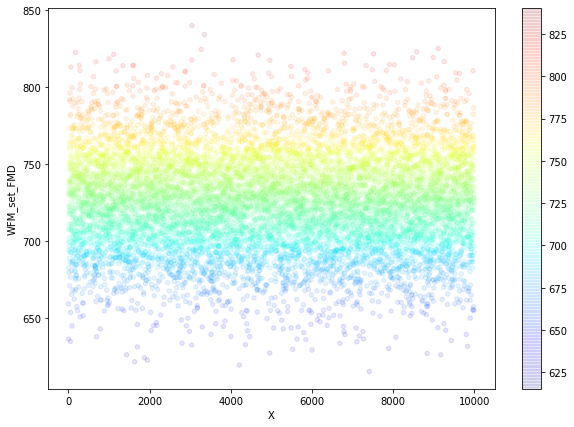

In [21]:
import pandas as pd

X = [k for k in range(K)]

Columns = ["WFM_set_FMD", "X"]

df_X_WFM_set_FMD = pd.DataFrame(np.append(WFM_set_FMD.reshape(1,K), np.array(X).reshape(1,K), axis=0).T, columns=Columns)

# 히스토그래프 그리기
plt.hist(WFM_set_FMD, bins=100)
# 데이터 분포와 크기에 따른 색상
df_X_WFM_set_FMD.plot(kind="scatter", x="X", y="WFM_set_FMD", alpha=0.1,
                      figsize=(10,7), c=df_X_WFM_set_FMD["WFM_set_FMD"],
                      cmap=plt.get_cmap("jet"), colorbar=True, sharex=False)

plt.show()

## 2.3 min-max과 shift를 이용해 거리를 구함

* min-max으로 데이터를 0\~1로 표준화를 시킨 후에 그 데이터의 middle보다 작거나 같은 값은 0\~1 사이의 값인데 제곱을 취하여 더 작은 값이 되도록 만든다.
* middle보다 큰 값은 middle이 1이 되도록 shift한 후 제곱을 취하여 더 큰 값이 되도록 한다.
* 거리의 maximum은 4 * K(테스트 케이스의 수)이다.

In [22]:
WFM_set_FMD = np.empty((0), dtype="float")
for k in range(K):
    WFM_k_FMD = 0
    for n, m in DAM_indexes:
        min_max_ED = (ED(TFM_mean[n][m],WFM_set[k][n][m])
                             - min[n][m]) / max[n][m]
        min_max_ED_of_middle = (middle[n][m]- min[n][m]) / max[n][m]
        if ED(TFM_mean[n][m],WFM_set[k][n][m]) <= middle[n][m]:
            WFM_k_FMD += (min_max_ED)**2
        else:
            WFM_k_FMD += (min_max_ED + 1 - min_max_ED_of_middle)**2
    
    WFM_set_FMD = np.append(WFM_set_FMD, WFM_k_FMD)
# FMDC 출력
print("FMDC:", WFM_set_FMD.min())

FMDC: 317.8229933647169


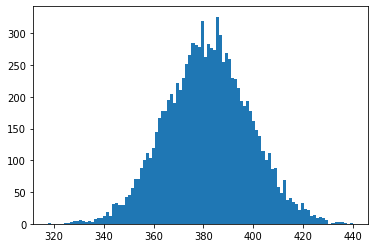

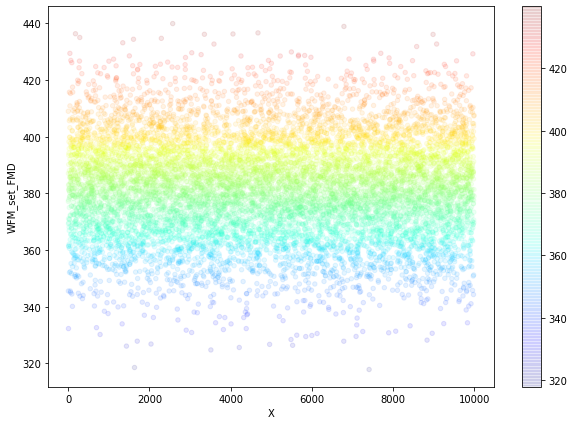

In [23]:
import pandas as pd

X = [k for k in range(K)]

Columns = ["WFM_set_FMD", "X"]

df_X_WFM_set_FMD = pd.DataFrame(np.append(WFM_set_FMD.reshape(1,K), np.array(X).reshape(1,K), axis=0).T, columns=Columns)

# 히스토그래프 그리기
plt.hist(WFM_set_FMD, bins=100)
# 데이터 분포와 크기에 따른 색상
df_X_WFM_set_FMD.plot(kind="scatter", x="X", y="WFM_set_FMD", alpha=0.1,
                      figsize=(10,7), c=df_X_WFM_set_FMD["WFM_set_FMD"],
                      cmap=plt.get_cmap("jet"), colorbar=True, sharex=False)

plt.show()